In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [40]:
from src.serialization_lib import *
from src.data_types import *
from IPython.display import HTML, display, Markdown

from collections import defaultdict
import pandas as pd
import statistics
import datetime
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# pd.set_option('display.max_colwidth', None)

pd.set_option('display.max_colwidth', 100)
pd.options.display.float_format = "{:,.2f}".format

In [3]:
INITIAL_PORTFOLIO_VALUE = 10000
# PORTFOLIO_SIZE = 30
# REBALANCE_DAYS = 90
PORTFOLIO_SIZE = 10
REBALANCE_DAYS = 365

BASE_METRIC = EvaluationMetric.EV_EBIT
TEST_METRIC = EvaluationMetric.P_B
STOCKS_UNIVERSE = StockUniverse.LARGE
PORTFOLIO_WEIGHT_STRATEGY = StockBasketWeightApproach.EQUAL_WEIGHTING

In [4]:
filename = df_feather_filename('df_debug', BASE_METRIC, TEST_METRIC, REBALANCE_DAYS, PORTFOLIO_SIZE, STOCKS_UNIVERSE)
df_debug = read_df_debug_from_feather(filename)

filename = df_feather_filename('df_res', BASE_METRIC, TEST_METRIC, REBALANCE_DAYS, PORTFOLIO_SIZE, STOCKS_UNIVERSE)
df_res = read_df_res_from_feather(filename)

In [5]:
all_df_results = defaultdict(lambda: defaultdict(pd.DataFrame))
all_rebalance_days = [90, 180, 730, 1825]
all_portfolio_sizes = [5, 10, 15, 30, 60]

for rebalance_days in all_rebalance_days:
    for portfolio_size in all_portfolio_sizes:
        filename = df_feather_filename('df_res', BASE_METRIC, TEST_METRIC, rebalance_days, portfolio_size, STOCKS_UNIVERSE)
        all_df_results[rebalance_days][portfolio_size] = read_df_res_from_feather(filename)


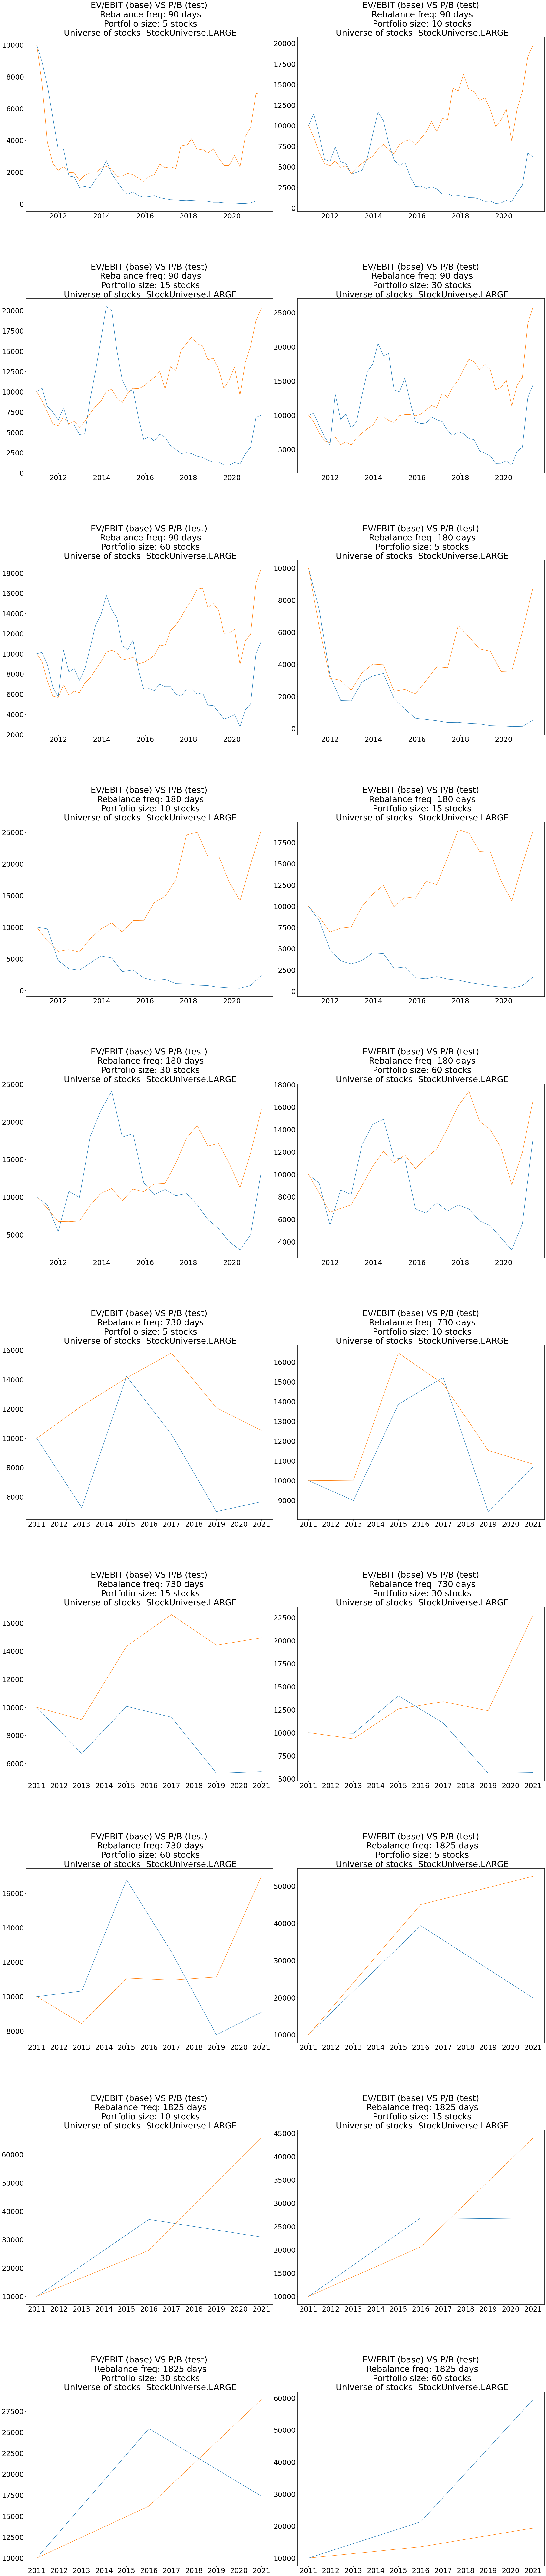

In [6]:
def plot_backtest(
    df: pd.DataFrame,
    base_metric: EvaluationMetric,
    test_metric: EvaluationMetric, 
    rebalance_days: int,
    portfolio_size: int,
    stocks_universe: StockUniverse,
    ax
):
    ax.set(title=(
        f'{str(base_metric)} (base)'
        f' VS {str(test_metric)} (test)\n'
        f' Rebalance freq: {rebalance_days} days\n'
        f' Portfolio size: {portfolio_size} stocks\n'
        f' Universe of stocks: {str(stocks_universe)}'))
    ax.plot(df.index, df['test_price'])
    ax.plot(df.index, df['base_price'])

plt.rcParams["font.size"] = "30"    
fig, axes = plt.subplots(
    nrows=int(len(all_rebalance_days) * len(all_portfolio_sizes) / 2),    
    ncols=2,
    figsize=(40,200),
    gridspec_kw={'hspace':0.5, 'wspace': 0.1})

row = 0
col = 0
for i, rebalance_days in enumerate(all_rebalance_days):
    for j, portfolio_size in enumerate(all_portfolio_sizes):
        plot_backtest(all_df_results[rebalance_days][portfolio_size], BASE_METRIC, TEST_METRIC, rebalance_days, portfolio_size, STOCKS_UNIVERSE, axes[row][col])
        col = col + 1
        if col == 2:
            row = row + 1
            col = 0

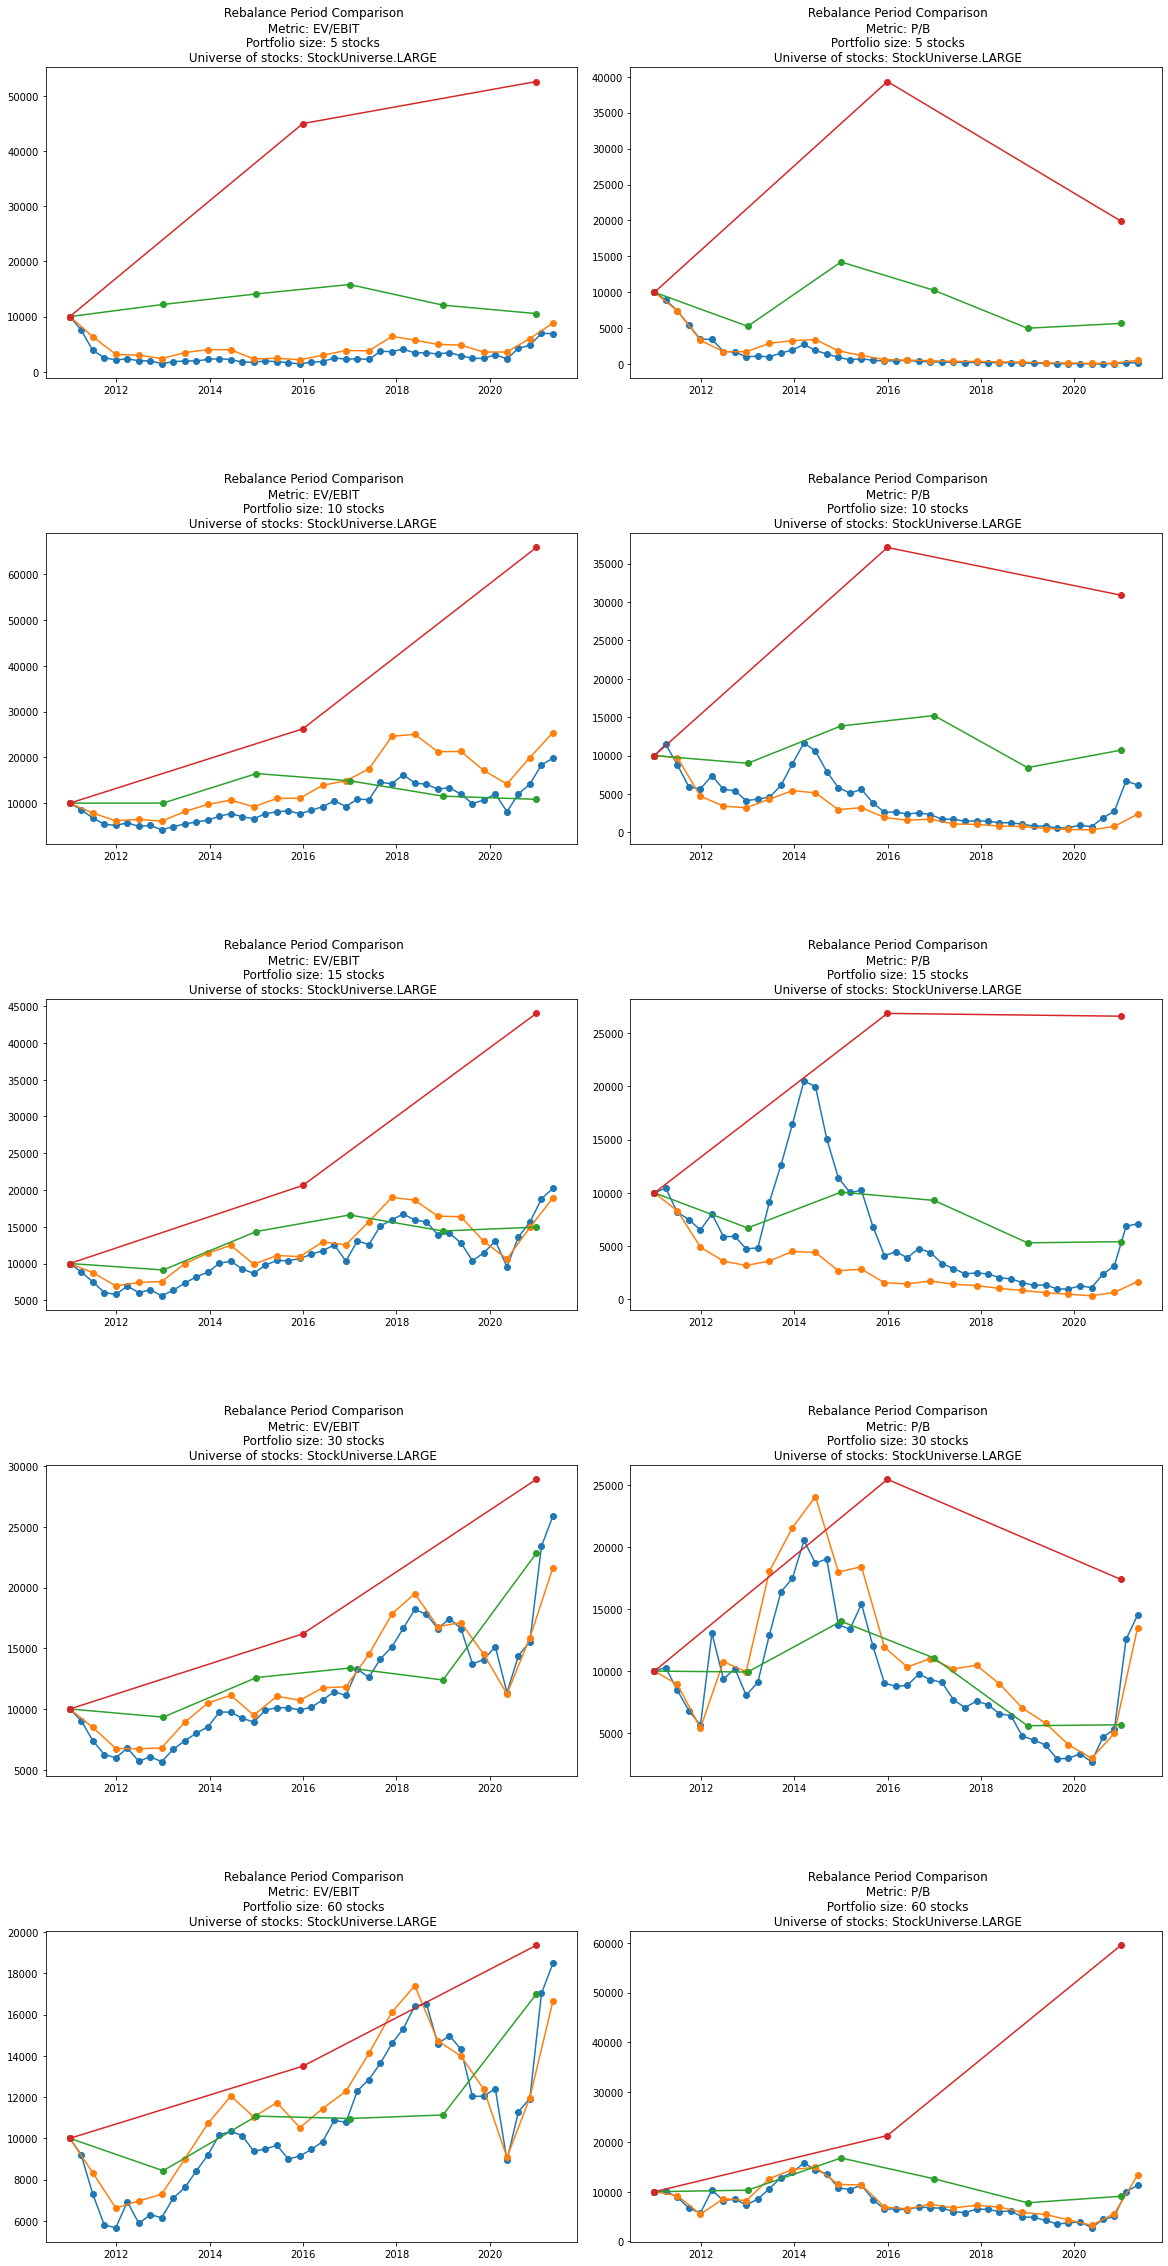

In [7]:
# For a specific portfolio size, plot performance of different rebalance days.

def plot_rebalance_days_investigation(
    df: pd.DataFrame,
    metric: EvaluationMetric,
    portfolio_size: int,
    all_rebalance_days: List[int],
    stocks_universe: StockUniverse,
    ax
):
    ax.set(title =(
        f' Rebalance Period Comparison\n'
        f' Metric: {str(metric)}\n'
        f' Portfolio size: {portfolio_size} stocks\n'
        f' Universe of stocks: {str(stocks_universe)}'))
    for rebalance_days in all_rebalance_days:
        series = df[f'price_{rebalance_days}']
        mask = ~np.isnan(series)
        ax.plot(df.index[mask], series[mask], marker='o') 

plt.rcParams["font.size"] = "10"    
fig, axes = plt.subplots(
    nrows=len(all_portfolio_sizes),
    ncols=2,
    figsize=(20,40),
    gridspec_kw={'hspace':0.5, 'wspace': 0.1})

for i, portfolio_size in enumerate(all_portfolio_sizes):
    df_base = pd.DataFrame(columns=['date'])
    df_test = pd.DataFrame(columns=['date'])

    for j, rebalance_days in enumerate(all_rebalance_days):
        df = all_df_results[rebalance_days][portfolio_size].reset_index()
        base_prices = df[['date', 'base_price']].rename(columns={'base_price': f'price_{rebalance_days}'})
        test_prices = df[['date', 'test_price']].rename(columns={'test_price': f'price_{rebalance_days}'})        

        df_base = df_base.merge(base_prices, how='outer', on='date')
        df_test = df_test.merge(test_prices, how='outer', on='date')        

    df_base = df_base.set_index('date').sort_index()
    df_test = df_test.set_index('date').sort_index()
        
    plot_rebalance_days_investigation(df_base, BASE_METRIC, portfolio_size, all_rebalance_days, STOCKS_UNIVERSE, axes[i][0])
    plot_rebalance_days_investigation(df_test, TEST_METRIC, portfolio_size, all_rebalance_days, STOCKS_UNIVERSE, axes[i][1])    


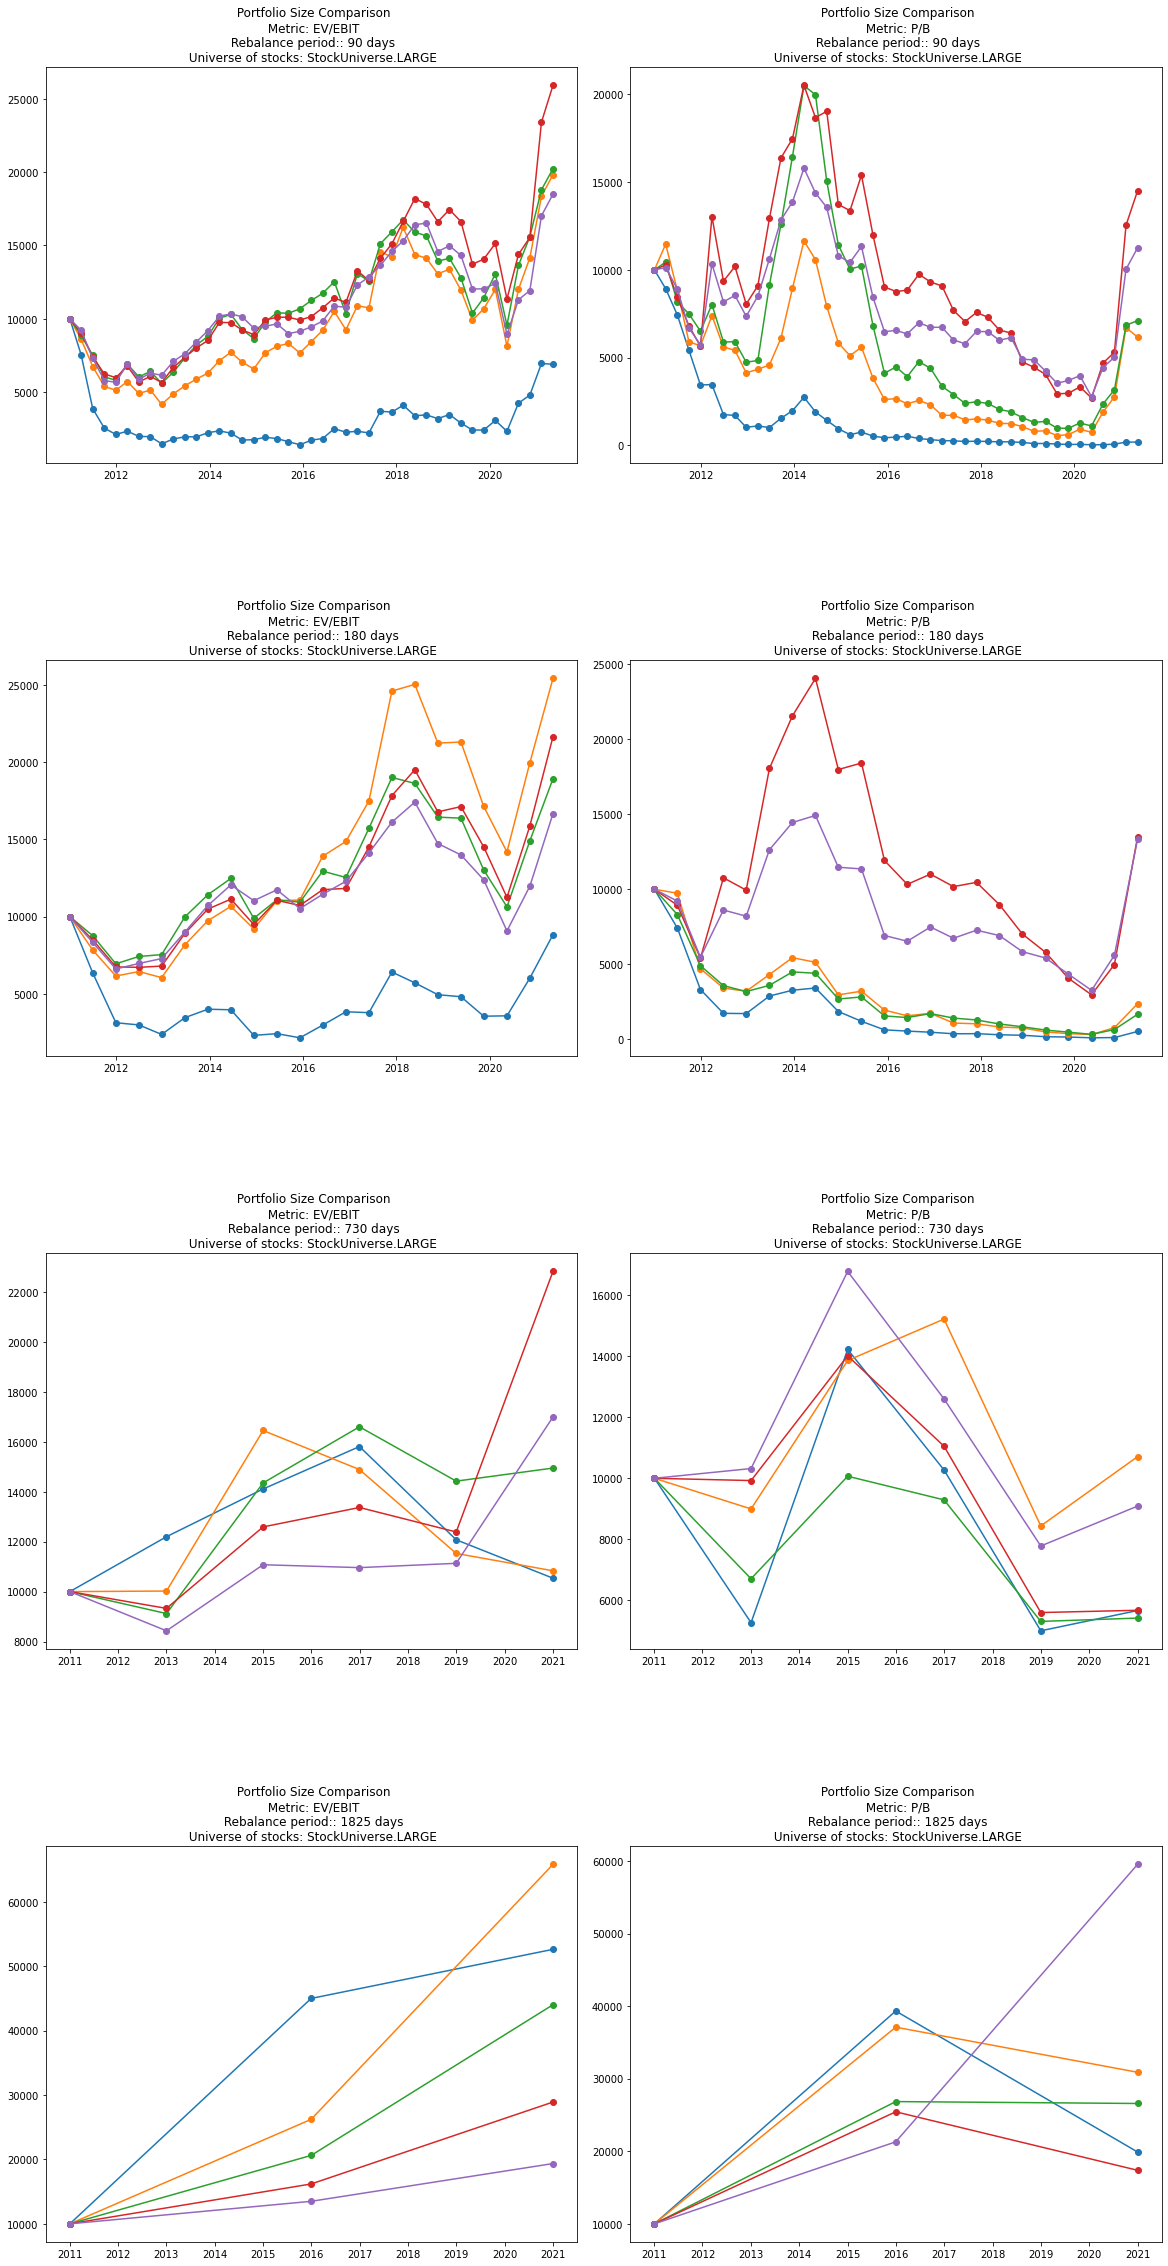

In [8]:
# For a specific rebalance period, plot performance of different rebalance days.

def plot_portfolio_size_investigation(
    df: pd.DataFrame,
    metric: EvaluationMetric,
    rebalance_days: int,
    stocks_universe: StockUniverse,
    ax
):
    df.plot(ax=ax, marker='o', title=(
        f' Portfolio Size Comparison\n'
        f' Metric: {str(metric)}\n'
        f' Rebalance period:: {rebalance_days} days\n'
        f' Universe of stocks: {str(stocks_universe)}'))      

def plot_rebalance_days_investigation(
    df: pd.DataFrame,
    metric: EvaluationMetric,
    rebalance_days: int,
    all_portfolio_sizes: List[int],
    stocks_universe: StockUniverse,
    ax
):
    ax.set(title =(
        f' Portfolio Size Comparison\n'
        f' Metric: {str(metric)}\n'
        f' Rebalance period:: {rebalance_days} days\n'
        f' Universe of stocks: {str(stocks_universe)}'))
    for portfolio_size in all_portfolio_sizes:
        series = df[f'price_{portfolio_size}']
        mask = ~np.isnan(series)
        ax.plot(df.index[mask], series[mask], marker='o') 

plt.rcParams["font.size"] = "10"    
fig, axes = plt.subplots(
    nrows=len(all_rebalance_days),
    ncols=2,
    figsize=(20,40),
    gridspec_kw={'hspace':0.5, 'wspace': 0.1})

for i, rebalance_days in enumerate(all_rebalance_days):
    df_base = pd.DataFrame(columns=['date'])
    df_test = pd.DataFrame(columns=['date'])

    for j, portfolio_size in enumerate(all_portfolio_sizes):
        df = all_df_results[rebalance_days][portfolio_size].reset_index()
        base_prices = df[['date', 'base_price']].rename(columns={'base_price': f'price_{portfolio_size}'})
        test_prices = df[['date', 'test_price']].rename(columns={'test_price': f'price_{portfolio_size}'})        

        df_base = df_base.merge(base_prices, how='outer', on='date')
        df_test = df_test.merge(test_prices, how='outer', on='date')        

    df_base = df_base.set_index('date').sort_index()
    df_test = df_test.set_index('date').sort_index()
        
    plot_rebalance_days_investigation(df_base, BASE_METRIC, rebalance_days, all_portfolio_sizes, STOCKS_UNIVERSE, axes[i][0])
    plot_rebalance_days_investigation(df_test, TEST_METRIC, rebalance_days, all_portfolio_sizes, STOCKS_UNIVERSE, axes[i][1])    


In [21]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
def color_per_cell(v):
    per = float(v if str(v)[-1] != '%' else str(v)[:-1])
    if per < -25:
        return "background-color: orangered"
    elif per >= -25 and per < 0:
        return "background-color: #ffcccb"
    elif per >= 0 and per < 25:
        return "background-color: #90ee90"
    elif per >= 25:
        return "background-color: green"

def display_two_decimal_places(val):
    return f'${val:,.2f}'

def display_date_only(d):
    return d.strftime('%Y-%m-%d')

def tuple_array_to_df(tuple_arr):
    df = pd.DataFrame.from_records(tuple_arr, columns=['ticker', 'prev', 'curr'])
    df['ticker'] = df['ticker'].str.replace("'", "")
    return df

def per_stocks_up(tupple_arr):
    return f'{round(100 * sum([1 for (ticker, prev, curr) in tupple_arr if (curr > prev)]) / len(tupple_arr), 2)}%'

def p_change(r):
    return f'{round(100 * (r.base_portfolio_curr_price - r.base_portfolio_prev_price ) / r.base_portfolio_prev_price, 2)}%'

def p_change2(r):
    return f'{round(100 * (r.curr - r.prev ) / r.prev, 2)}%'

def get_date_based_df(df_debug, date):
    df_date = df_debug.loc[date]
    tuple_arr = df_date['base_portfolio_per_ticker_data']
    df = tuple_array_to_df(tuple_arr)
    tickers_closed = [str(s) for s in df_date['base_portfolio_tickers_closed']]
    df['up'] = df.apply(lambda r: r['curr'] > r['prev'], axis=1)
    df['per_change'] = df.apply(lambda r: p_change2(r), axis=1)
    df['did_close'] = df.apply(lambda r: "Closed" if str(r.ticker) in tickers_closed else "", axis=1)
    df = df.sort_values(by='per_change', key=lambda col: col.map(lambda v: float(v[:-1])))    
    summary_row = [
        'Summary / Total ',
        round(sum(df['prev']), 20),
        round(sum(df['curr']), 20),
        f"{round(100 * sum(df['up']) / len(df['up']))}%",
        f"{round(statistics.mean([float(p[:-1]) for p in df['per_change']]), 2)}%",
        ""
    ]
    df.loc[len(df.index)] = summary_row
    return df

df_debug['per_stock_up'] = df_debug.apply(lambda r: per_stocks_up(list(r.base_portfolio_per_ticker_data)), axis=1)
df_debug['portfolio_change'] = df_debug.apply(lambda r: p_change(r), axis=1)

df_debug_readable = df_debug.copy()
df_debug_readable['num_tickers_closed'] = df_debug_readable.apply(lambda r: len(r.base_portfolio_tickers_closed), axis=1)
df_debug_readable = df_debug_readable.drop(['base_portfolio_tickers_closed', 'base_portfolio_per_ticker_data', 'new_base_portfolio_per_ticker_data'], axis=1)
df_debug_readable.rename(columns={'base_portfolio_prev_price': 'prev', 'base_portfolio_curr_price': 'curr'}, inplace=True)

date_to_inspect = df_debug.index[7]
df_date = get_date_based_df(df_debug, date_to_inspect)

In [43]:
df_debug_with_style = df_debug_readable.round(2).style \
    .format({
        'curr': display_two_decimal_places,
        'prev': display_two_decimal_places,
        'date': display_date_only,
        'prev_date': display_date_only,
        'curr_date': display_date_only,    
    }).set_caption(
        f"Return for \n" \
        f" for {str(STOCKS_UNIVERSE)}\n" \
        f" for {str(BASE_METRIC)}" \
        f" for rebalance period: {str(REBALANCE_DAYS)}" \
        f" for portfolio size: {str(PORTFOLIO_SIZE)}" \
    ).set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'black'),
            ('font-size', '16px'),
            ('text-align', 'center'),        
        ]}])

HTML(df_debug_with_style.applymap(color_per_cell, subset=['per_stock_up', 'portfolio_change']).render())

,prev_date,curr_date,prev,curr,per_stock_up,portfolio_change,num_tickers_closed
date,,,,,,,
2012-01-03 00:00:00,2011-01-03,2012-01-03,"$10,000.00","$7,218.19",10.0%,-27.82%,0
2013-01-02 00:00:00,2012-01-03,2013-01-02,"$7,218.19","$7,290.88",50.0%,1.01%,0
2014-01-02 00:00:00,2013-01-02,2014-01-02,"$7,290.88","$11,416.82",100.0%,56.59%,1
2015-01-02 00:00:00,2014-01-02,2015-01-02,"$11,416.82","$15,426.73",70.0%,35.12%,2
2015-12-31 00:00:00,2015-01-02,2015-12-31,"$15,426.73","$13,048.48",50.0%,-15.42%,2
2016-12-30 00:00:00,2015-12-31,2016-12-30,"$13,048.48","$13,912.36",60.0%,6.62%,0
2017-12-29 00:00:00,2016-12-30,2017-12-29,"$13,912.36","$15,944.03",70.0%,14.6%,0
2018-12-31 00:00:00,2017-12-29,2018-12-31,"$15,944.03","$11,130.60",20.0%,-30.19%,0
2019-12-31 00:00:00,2018-12-31,2019-12-31,"$11,130.60","$10,205.62",40.0%,-8.31%,0


In [37]:
df_with_style = df_date.style \
    .format({
        'curr': display_two_decimal_places,
        'prev': display_two_decimal_places,
    }) \
    .set_caption(
        f"Rebalance results" \
        f" on {datetime.datetime.strftime(date_to_inspect, '%Y-%m-%d')}" \
        f" for {str(STOCKS_UNIVERSE)}" \
        f" for {str(BASE_METRIC)}") \
    .set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'black'),
            ('font-size', '16px'),
            ('text-align', 'center'),        
        ]
}])

HTML(df_with_style.applymap(color_per_cell, subset=['per_change']).render())

,ticker,prev,curr,up,per_change,did_close
1,ALT,$59.70,$2.06,False,-96.55%,
9,TKAT,$2.51,$0.68,False,-72.87%,
5,NAVB,$7.17,$2.05,False,-71.37%,
3,CCUR,$5.21,$2.99,False,-42.71%,
0,ACTG,$4.05,$2.98,False,-26.42%,
6,NHLD,$3.30,$2.70,False,-18.18%,
2,BK,$49.20,$43.86,False,-10.85%,
8,NTIP,$2.09,$2.01,False,-3.68%,
4,MBIN,$18.82,$19.27,True,2.43%,
7,NHTC,$10.13,$14.01,True,38.31%,


In [38]:
def cagr(start, end, n):
    cagr = pow(end / start, 1 / n) - 1
    return cagr * 100

def value_growth(cagr, n):
    return 10000 * pow(1 + cagr / 100, n)    

def display_data(data, caption):
    df = pd.DataFrame(data, columns = ['Time Period', 'CAGR', 'SD', '$10,000 grows to...'])
    df = df.style.set_caption(caption)\
        .format({"CAGR": "{:.2f}%", "SD": "{:.2f}%", '$10,000 grows to...': "${:,.2f}"}) \
        .set_table_styles([{
            'selector': 'caption',
            'props': [
                ('color', 'black'),
                ('font-size', '16px'),
                ('text-align', 'center'),        
            ]
        }])
    display(HTML(df.applymap(color_per_cell, subset=['CAGR', 'SD']).render()))

min_date = min(df_res.index)
max_date = max(df_res.index)

time_period_table_days = 365 * 1 # 1 year(s)

tabulated_base_data = []
tabulated_test_data = []

period_start_date = min_date

idx_s = 0
idx_e = 0

for date, data in df_res.iterrows():
    idx_e += 1
    td = (date - period_start_date)
    if (td.days >= time_period_table_days - 5) and idx_s < len(df_res):
        n = round(td.days / 365)    
        df = df_res.iloc[idx_s:idx_e]
        
        prev_data = df_res.iloc[idx_s]
        curr_data = df_res.iloc[idx_e]
        
        period_start_dateiod = list(d.strftime('%Y-%m-%d') for d in [period_start_date, date])
        
        base_start_p = prev_data['base_price']
        base_end_p = curr_data['base_price']
        base_cagr = cagr(base_end_p, base_start_p, n)
        base_sd = np.std(df['base_price'].values)
        base_sd = base_sd / np.sum(df['base_price'].values) * 100
        base_growth = value_growth(base_cagr, n)
        
        tabulated_base_data.append([period_start_dateiod, base_cagr, base_sd, base_growth])
        
        test_start_p = prev_data['test_price']
        test_end_p = curr_data['test_price']
        test_cagr = cagr(test_start_p, test_end_p, n)
        test_sd = np.std(df['test_price'].values)
        test_sd = test_sd / np.sum(df['test_price'].values) * 100
        test_growth = value_growth(test_cagr, n)

        tabulated_test_data.append([period_start_dateiod, test_cagr, test_sd, test_growth])
        
        idx_s = idx_e + 1
        idx_e += 1
        period_start_date = date
        

display_data(tabulated_base_data, f"{BASE_METRIC}")
display_data(tabulated_test_data, f"{TEST_METRIC}")

,Time Period,CAGR,SD,"$10,000 grows to..."
0,"['2011-01-03', '2012-01-03']",37.16%,8.08%,"$13,715.77"
1,"['2012-01-03', '2013-01-02']",-25.99%,0.00%,"$7,400.67"
2,"['2013-01-02', '2014-01-02']",-6.21%,0.00%,"$9,379.06"
3,"['2014-01-02', '2015-01-02']",43.25%,0.00%,"$14,324.50"
4,"['2015-01-02', '2015-12-31']",-37.47%,0.00%,"$6,253.12"


,Time Period,CAGR,SD,"$10,000 grows to..."
0,"['2011-01-03', '2012-01-03']",153.35%,9.48%,"$25,335.50"
1,"['2012-01-03', '2013-01-02']",-43.25%,0.00%,"$5,674.81"
2,"['2013-01-02', '2014-01-02']",22.20%,0.00%,"$12,220.27"
3,"['2014-01-02', '2015-01-02']",-47.58%,0.00%,"$5,242.00"
4,"['2015-01-02', '2015-12-31']",-11.82%,0.00%,"$8,818.04"
